# Overfitting for model tuning

Investigate model created by running the following command line:

`python train_unet_multi_task_2.py --output ../../dsb-2018/models/model-dsbowl2018-unet-ext_2.h5 --epochs 800 --samples 2`

In [1]:
import random

import keras.models
from skimage.io import imshow

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tools import sources
from tools import unetmodel
from tools import rect

from skimage.transform import resize

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    _, axs = plt.subplots(ncols=n, figsize=(15, 5))
    
    for ix, ax in enumerate(axs):
        ax.imshow(imgs[ix])
        ax.axis('off')
        
        if titles:
            ax.set_title(titles[ix])

In [35]:
# Loading 8 images of reference data

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

ztx, zty, ztc, zto, ztdx1, ztdy1, ztdx2, ztdy2, ztrm, _ = sources.flattened_trainset_ex_2(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, 8)

100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


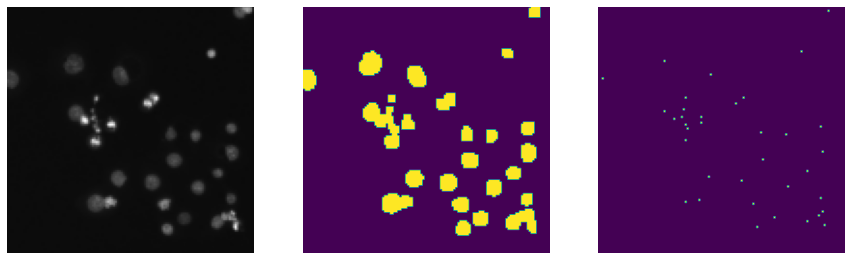

In [36]:
# Look at input, ground truth and computed nuclei center for first image

ix = 0
show_imgs([ztx[ix], zty[ix], ztc[ix]])

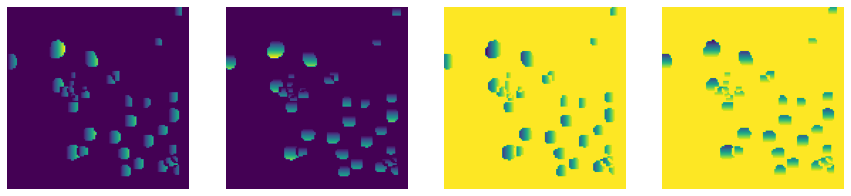

In [5]:
# We are looking at bounding box coordinates around centers

show_imgs([ztdx1[ix], ztdy1[ix], ztdx2[ix], ztdy2[ix], ])

In [6]:
# Compile to False because testing is not needed
# This way custom loss functions are not needed
model_ext_2 = keras.models.load_model(sources.MODEL_PATH + '/model-dsbowl2018-unet-ext_2.h5', compile=False)

In [7]:
pty, ptc, pto, ptdx1, ptdy1, ptdx2, ptdy2 = model_ext_2.predict(ztx)

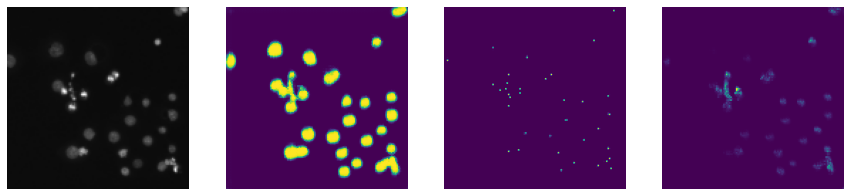

In [8]:
# Look at input, predicted masks, centers and overlaps (the latter is not used)

show_imgs([ztx[ix], pty[ix], ptc[ix], pto[ix]])

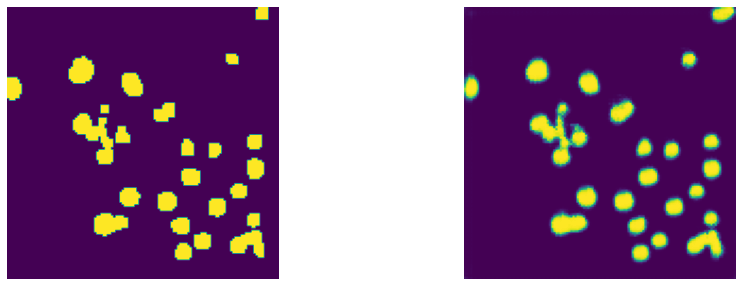

In [9]:
# Focus on ground truth and predicted masks

show_imgs([zty[ix], pty[ix]])

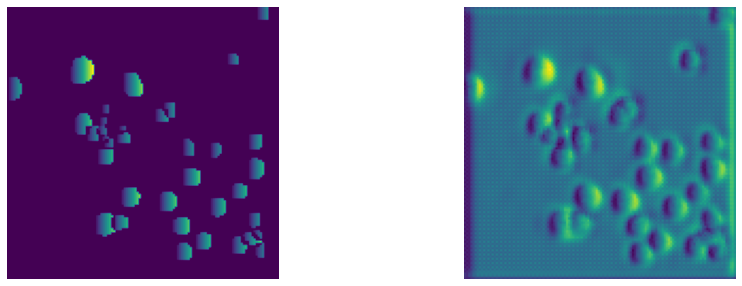

In [10]:
# The predicted left side of bounding boxes (doesn't look great outside cells but we use the center data anyway)

show_imgs([ztdx1[ix], ptdx1[ix]])

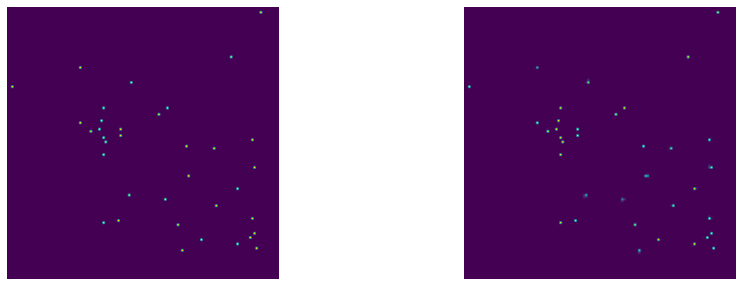

In [11]:
# Focus of centers

show_imgs([ztc[ix], ptc[ix]])

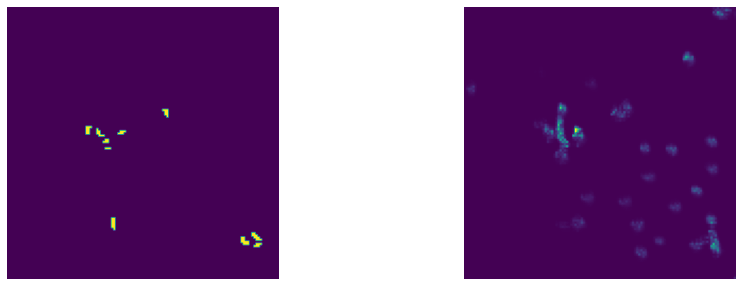

In [12]:
# Check overlaps
# The quality is not great, but I think it is not used very well.

show_imgs([zto[ix], pto[ix]])

## Rectangle collection

In [26]:
def get_rects_from_centers(ix, ztc, dx1, dx2, dy1, dy2, thr=0.0):
    rects = []
    for x in range(128):
        for y in range(128):
            if ztc[ix][y, x] > thr:
                rects.append((int(x-dx1[ix][y,x]), int(x-dx2[ix][y,x]), int(y-dy1[ix][y,x]), int(y-dy2[ix][y,x])))
    return rects

In [27]:
import matplotlib.patches as patches

def show_rects(rects, ix, zty):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(zty[ix])

    for (x1, x2, y1, y2) in rects:
        # Create a Rectangle patch and add patch to Axes
        ax.add_patch(patches.Rectangle((x1,y1),int(x2-x1+1),int(y2-y1+1),linewidth=1,edgecolor='r',facecolor='none'))

    plt.show()

In [31]:
rects = get_rects_from_centers(ix, ztc, ptdx1, ptdx2, ptdy1, ptdy2)

In [32]:
len(rects)

36

In [33]:
rects[:4]

[(0, 7, 32, 43), (29, 41, 22, 37), (31, 40, 50, 59), (36, 43, 55, 61)]

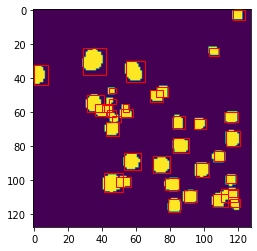

In [34]:
# The predicted bounding boxes fit well the ground truth
# That's expected as we are overfitting the two first images

show_rects(rects, ix, zty)

In [18]:
# Try it on the fifth image

rects = get_rects_from_centers(5, ptc, thr=0.05)

In [19]:
len(rects)

18

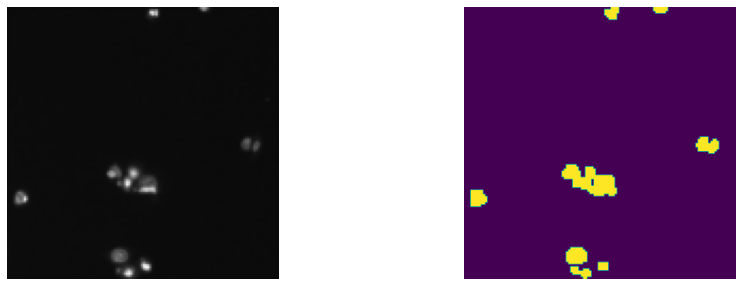

In [20]:
show_imgs([ztx[5], zty[5]])

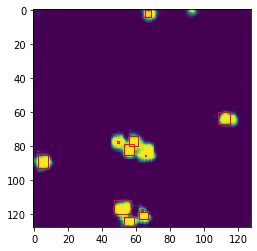

In [21]:
show_rects(rects, 5, pty)